# Importer les fichiers et les modules

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
import datetime
import edc
from edc import maps
from edc import utils

%load_ext autoreload
%autoreload 2

In [2]:
df_cities = pd.read_csv("../data/cities.csv")
df_factors = pd.read_csv("../data/factors.csv")
df_orders = pd.read_csv("../data/orders.csv")
df_packages = pd.read_csv("../data/packages.csv")
df_pricing = pd.read_csv("../data/pricing.csv")
df_routes = pd.read_csv("../data/routes_v2.csv")
df_trucks = pd.read_csv("../data/trucks.csv")
df_warehouses = pd.read_csv("../data/warehouses.csv")

# Premier traitement des données

In [3]:
df_cities.population_proper = df_cities.apply(lambda row : int(row.population_proper),axis=1)
df_cities.population = df_cities.apply(lambda row : int(row.population),axis=1)
df_orders.n_units = df_orders.apply(lambda row : int(row.n_units),axis=1)

df_orders.order_date = pd.to_datetime(df_orders.order_date)
df_orders.delivered_date = pd.to_datetime(df_orders.delivered_date)

On définit des constantes dans notre analyse.

In [4]:
volume_truck = float(df_factors[df_factors.name == 'truck_volume'].value)
cout_par_km = float(df_factors[df_factors.name == "cost_per_liter"]['value']) * float(df_factors[df_factors.name == "fuel_per_km"]['value']) * 4
CO2_per_km = 0.795

On crée des features, et on lie les trajets aux commandes pour avoir une base de données assez complète.

In [5]:
df_routes['orders_list'] = df_routes.apply(lambda row : row.orders.split(" > "),axis=1)
df_routes['stops_list'] = df_routes.apply(lambda row : row.stops.split(" > "),axis=1)
df_routes['nb_stops'] = df_routes.apply(lambda row : len(row.orders_list),axis=1)
df_routes['distance_retour_entrepot'] = df_routes.apply(lambda row : utils.dist(utils.donnees_cities(row.stops_list[-1]),utils.donnees_cities(row.from_warehouse)), axis=1)
df_routes['distance_aller_retour'] = df_routes['total_distance'] + df_routes['distance_retour_entrepot'] 
df_routes['CO2_emitted_kg'] = df_routes.apply(lambda row : row.distance_aller_retour * CO2_per_km, axis=1)

Calculons le CO2 émis sur 6 mois.

In [6]:
df_routes.distance_aller_retour.sum() * CO2_per_km

3444404.7987809475

In [7]:
liste = []
for i in range(len(df_routes.nb_stops)):
    liste.append(list(np.arange(df_routes.nb_stops.iloc[i])))

merged = list(itertools.chain.from_iterable(liste))

df_routes_orders = df_routes.loc[df_routes.index.repeat(df_routes.nb_stops)]
df_routes_orders.index = np.arange(len(df_routes_orders))
df_routes_orders = pd.concat( [df_routes_orders, pd.DataFrame(merged,columns=['index_order'])] , axis=1 , ignore_index=False)
df_routes_orders['order_id'] =  df_routes_orders.apply(lambda row : row.orders_list[row.index_order],axis=1)
df_routes_orders.drop(columns=["orders","from_warehouse"],inplace=True)
df_routes_orders = pd.merge(df_routes_orders,df_orders,on='order_id',how='left',suffixes=("_route","_order"))
df_routes_orders['ratio_unitary_volume'] = df_routes_orders.apply(lambda row : row.package_volume / row.fill_volume,axis=1)
df_routes_orders['unitary_cout'] = df_routes_orders.apply(lambda row : row.ratio_unitary_volume * cout_par_km * row.total_distance ,axis=1)
df_routes_orders['unitary_CO2'] = df_routes_orders.apply(lambda row : row.ratio_unitary_volume * row.CO2_emitted_kg,axis=1)
df_routes_orders['CO2_per_m3'] = df_routes_orders.apply(lambda row : row.unitary_CO2 / row.package_volume,axis=1)

In [8]:
def f_package_type(row):
    for i in range(len(df_pricing)):
        if row.package_volume <= df_pricing.loc[i].max_volume :
            return i
    print("The volumes exceeds the maximal size")

df_routes_orders['package_type'] = df_routes_orders.apply(f_package_type,axis=1)
df_routes_orders["revenus"] = df_routes_orders.apply(lambda row : df_pricing.loc[row.package_type].pricing, axis=1)
df_routes_orders["profit"] = df_routes_orders.apply(lambda row : row.revenus - row.unitary_cout, axis=1)

In [9]:
df_routes_orders.profit.sum()

864028.8025246033

# Visualisation

Voyons combien de produits identiques sont dans chaque commande

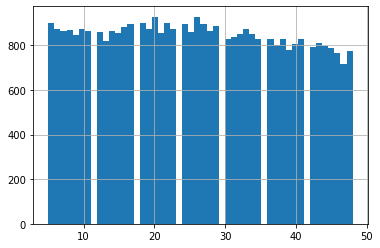

In [10]:
df_orders.n_units.hist(bins=50);

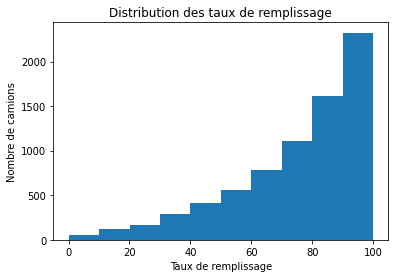

In [11]:
plt.xlabel("Taux de remplissage")
plt.ylabel("Nombre de camions")
plt.hist(df_routes.fill_volume / volume_truck * 100, bins=10)
plt.title("Distribution des taux de remplissage");

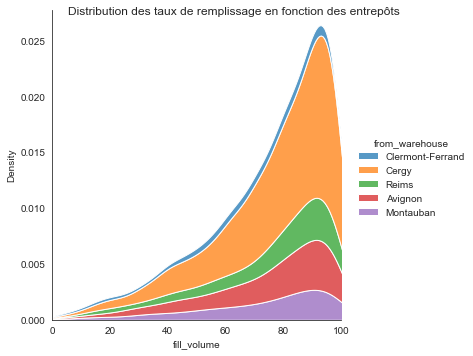

In [12]:
sns.set_style(style='white')
g = sns.displot(x=df_routes["fill_volume"]/ volume_truck * 100, hue=df_routes["from_warehouse"], kind="kde",multiple="stack")
g.fig.suptitle("Distribution des taux de remplissage en fonction des entrepôts")
g.set(xlim=(0, 100));

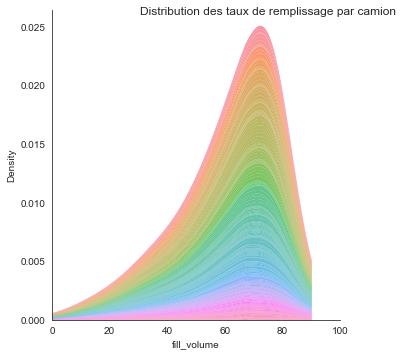

In [13]:
g = sns.displot(df_routes, x="fill_volume", hue="truck_id", kind="kde",multiple="stack",linewidth = 0)
g._legend.remove()
g.fig.suptitle("Distribution des taux de remplissage par camion")
g.set(xlim=(0, 100));

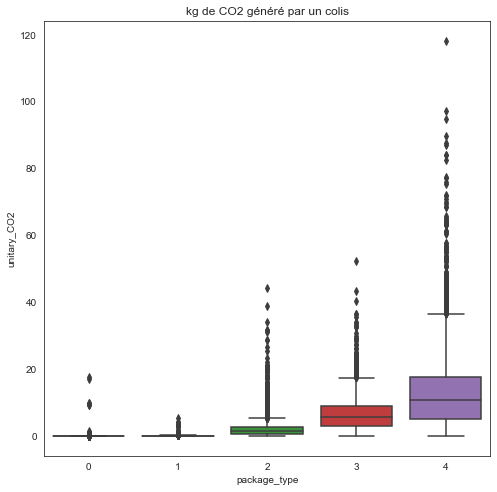

In [14]:
plt.figure(figsize=(8,8))
sns.boxplot(x="package_type", y="unitary_CO2", data=df_routes_orders)
plt.title("kg de CO2 généré par un colis");

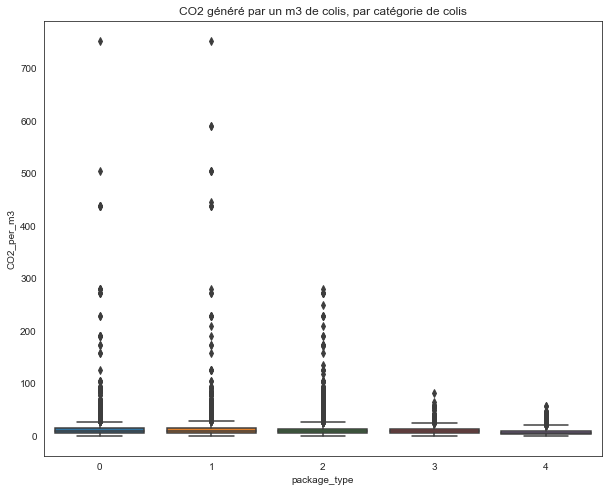

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(x="package_type", y="CO2_per_m3", data=df_routes_orders[df_routes_orders.CO2_per_m3<1000])
plt.title("CO2 généré par un m3 de colis, par catégorie de colis");

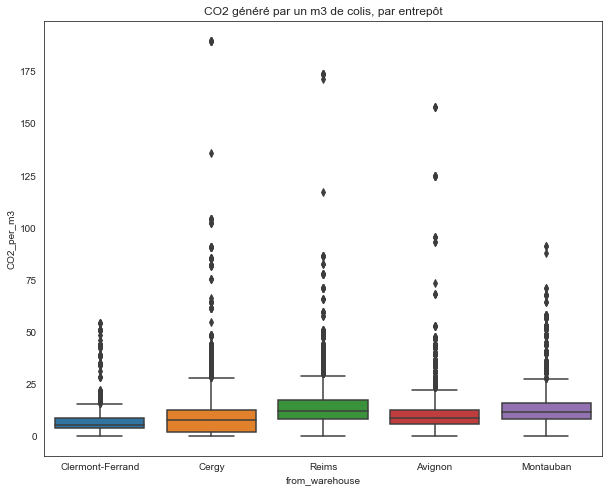

In [16]:
plt.figure(figsize=(10,8))
sns.boxplot(x="from_warehouse", y="CO2_per_m3", data=df_routes_orders[df_routes_orders.CO2_per_m3<200])
plt.title("CO2 généré par un m3 de colis, par entrepôt");

In [17]:
df_routes.route_date = pd.to_datetime(df_routes.route_date)

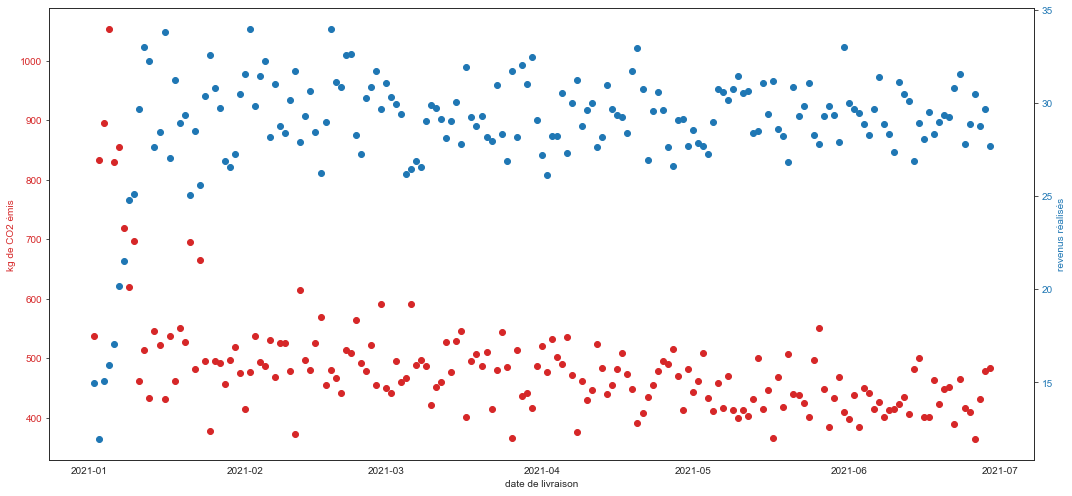

In [18]:
t = df_routes.groupby("route_date").mean().index

fig, ax1 = plt.subplots(figsize=(15,7))

color = 'tab:red'
ax1.set_xlabel('date de livraison')
ax1.set_ylabel('kg de CO2 émis', color=color)
ax1.scatter(t, df_routes.groupby("route_date").mean().CO2_emitted_kg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('revenus réalisés', color=color)  # we already handled the x-label with ax1
ax2.scatter(t, df_routes_orders.groupby("route_date").mean().revenus, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On voit que beaucoup de CO2 a été émis en début d'année.

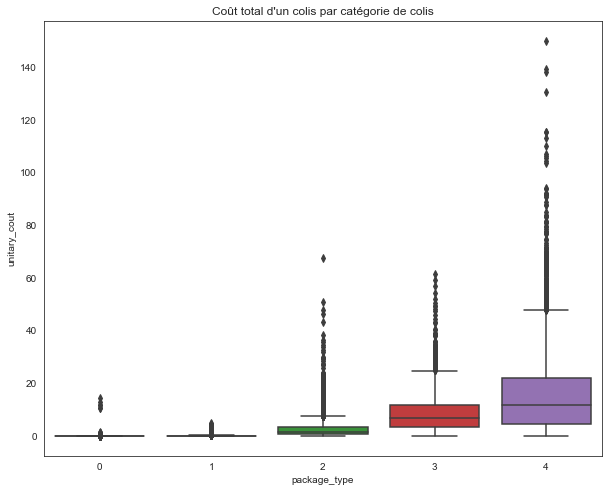

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x="package_type", y="unitary_cout", data=df_routes_orders)
plt.title("Coût total d'un colis par catégorie de colis");

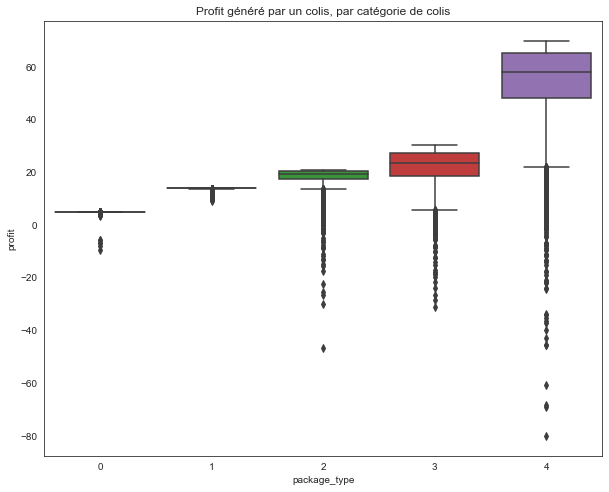

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(x="package_type", y="profit", data=df_routes_orders)
plt.title("Profit généré par un colis, par catégorie de colis");

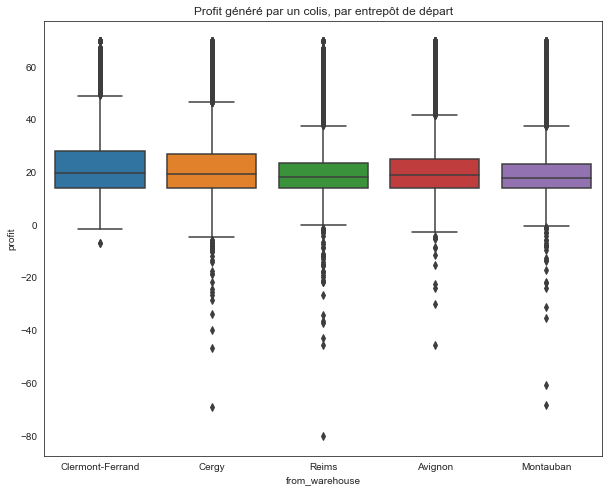

In [21]:
plt.figure(figsize=(10,8))
sns.boxplot(x="from_warehouse", y="profit", data=df_routes_orders)
plt.title("Profit généré par un colis, par entrepôt de départ");

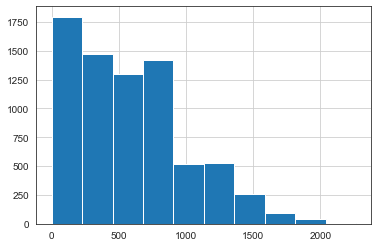

In [22]:
total_dists = df_routes.distance_aller_retour
total_dists.hist(bins=10);

In [23]:
df_routes_orders.keys()

Index(['truck_id', 'duration', 'fill_volume', 'n_units_route', 'route_date',
       'stops', 'total_distance', 'orders_list', 'stops_list', 'nb_stops',
       'distance_retour_entrepot', 'distance_aller_retour', 'CO2_emitted_kg',
       'index_order', 'order_id', 'package_id', 'package_volume',
       'delivery_location', 'from_warehouse', 'order_date', 'delivered_date',
       'n_units_order', 'order_total_volume', 'ratio_unitary_volume',
       'unitary_cout', 'unitary_CO2', 'CO2_per_m3', 'package_type', 'revenus',
       'profit'],
      dtype='object')

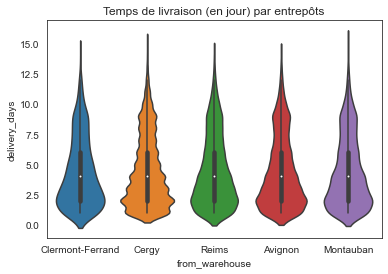

In [24]:
df_routes_orders["delivery_days"] = (df_routes_orders["delivered_date"]-df_routes_orders["order_date"]).dt.days
sns.violinplot(x="from_warehouse", y="delivery_days", data=df_routes_orders).set_title('Temps de livraison (en jour) par entrepôts');

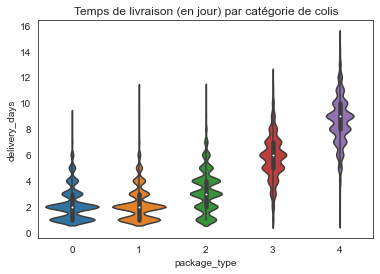

In [25]:
sns.violinplot(x="package_type", y="delivery_days", data=df_routes_orders).set_title('Temps de livraison (en jour) par catégorie de colis');

In [26]:
df_routes_orders.to_csv("..\data\intermediate_data\df_routes_orders.csv")

# Visualisation géographique

In [27]:
df_carte_point = pd.merge( df_orders.groupby("delivery_location").sum("delivery_location"), 
                          df_cities[["population","city","lat","lng"]], 
                          right_on="city", 
                          left_on="delivery_location"
                          )

In [28]:
df_orders_per_warehouse = pd.DataFrame(df_orders.groupby(["from_warehouse","delivery_location"]).sum().to_records())
df_1 = pd.merge(df_orders_per_warehouse,
                df_cities[["city","lat","lng"]],
                left_on="from_warehouse",
                right_on="city"
                ).rename(columns={'lat':'lat_warehouse','lng':'lng_warehouse'}).drop(columns=['city'])
df_orders_lines = pd.merge(df_1,
                           df_cities[["city","lat","lng"]],
                           left_on="delivery_location",
                           right_on="city").rename(columns={'lat':'lat_delivery','lng':'lng_delivery'})
del(df_1)

In [29]:
df_cities.population_proper = df_cities.apply(lambda row : int(row.population_proper),axis=1)
df_cities.population = df_cities.apply(lambda row : int(row.population),axis=1)
df_orders.n_units = df_orders.apply(lambda row : int(row.n_units),axis=1)

df_orders.order_date = pd.to_datetime(df_orders.order_date)
df_orders.delivered_date = pd.to_datetime(df_orders.delivered_date)

df_orders_lines.to_csv("..\data\intermediate_data\df_orders_lines.csv")
df_carte_point.to_csv("..\data\intermediate_data\df_carte_point.csv")

Nous allons représenter quelles villes sont desservies par quel entrepôt. 
- Plus une ville est de couleur noire, plus elle reçoit des colis
- Plus une ligne est épaisse, plus le nombre de colis acheminés depuis l'entrepôt est important

In [30]:
m = folium.Map()

colormap = cm.LinearColormap(colors=['white','black'], vmin=df_carte_point.order_total_volume.min(),vmax=df_carte_point.order_total_volume.max())
colormap.caption = 'order total volume'

df_carte_point.apply(lambda point : edc.maps.plotDot(m,point,colormap=colormap), axis = 1)
m.add_child(colormap,name='order total volume')
#Set the zoom to the maximum possible
m.fit_bounds(m.get_bounds())

df_cities[df_cities.is_warehouse].apply(lambda point : edc.maps.plotMarker(m,point), axis = 1)
df_orders_lines.apply(lambda order : edc.maps.plotLine(m,order),axis=1)

m

Nous avons repéré quelques trajets très mals optimisés.

In [31]:
m = folium.Map()

colormap = cm.LinearColormap(colors=['white','black'], vmin=df_carte_point.order_total_volume.min(),vmax=df_carte_point.order_total_volume.max())
colormap.caption = 'order total volume'

df_carte_point.apply(lambda point : edc.maps.plotDot(m,point,colormap), axis = 1)
m.add_child(colormap,name='order total volume')

#Set the zoom to the maximum possible
m.fit_bounds(m.get_bounds())
df_cities[df_cities.is_warehouse].apply(lambda point : maps.plotMarker(m,point), axis = 1)

cities = list(df_routes[(df_routes.truck_id == "9xU3UQ9KDwAJv66hEJtrrT") &(df_routes.route_date == datetime.datetime(2021, 1, 5))].stops)[0].split(' > ')
maps.plotTrajectoire(m,cities)

cities = list(df_routes[(df_routes.truck_id == "Ac4Ywptf5faCzxS8JJvqP7")&(df_routes.route_date == datetime.datetime(2021, 3, 24))].stops)[0].split(' > ')
maps.plotTrajectoire(m,cities,color="red")

m

In [32]:
m = folium.Map()

colormap = cm.LinearColormap(colors=['white','black'], vmin=df_carte_point.order_total_volume.min(),vmax=df_carte_point.order_total_volume.max())
colormap.caption = 'order total volume'

df_carte_point.apply(lambda point : maps.plotDot(m,point,colormap), axis = 1)
m.add_child(colormap,name='order total volume')

#Set the zoom to the maximum possible
m.fit_bounds(m.get_bounds())
df_cities[df_cities.is_warehouse].apply(lambda point : maps.plotMarker(m,point), axis = 1)

old_list = ["Avignon","Vénissieux","Nice","Montélimar","Grenoble","Cannes","Béziers","Annecy"]
new_list = ["Avignon","Béziers","Montélimar","Vénissieux","Annecy","Grenoble","Nice","Cannes"]

#cities = list(df_routes[(df_routes.truck_id == "9xU3UQ9KDwAJv66hEJtrrT") &(df_routes.route_date == datetime.datetime(2021, 1, 5))].stops)[0].split(' > ')
maps.plotTrajectoire(m,old_list)

#cities = list(df_routes[(df_routes.truck_id == "Ac4Ywptf5faCzxS8JJvqP7")&(df_routes.route_date == datetime.datetime(2021, 3, 24))].stops)[0].split(' > ')
maps.plotTrajectoire(m,new_list,color="red")

m